# 用Bokeh创建动画

In [1]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

所谓静态动画是指动画一旦创建就再也不与Python内核相关，所有的动画数据都在图表创建时作为JSON数据传递给客户端处理。动画效果由Javascript程序实现。

In [2]:
from bokeh.plotting import Figure
from bokeh.models import ColumnDataSource

## 多体运动模拟动画

最后让我们用`show_figure_with_callback()`制作一个多体运动的模拟动画。下面是计算多体运动轨迹程序，`data`是表示每个质点位置的数组，`json_data`是将该数组对应的JSON字符串。数组的形状为(轨迹的长度，X-Y轴，质点数)。因此`data[:, 0, 0]`为第一个质点运动轨迹的X轴坐标。

In [3]:
import numpy as np
import json
from scipy import integrate

N = 5

np.random.seed(42)
status = np.r_[np.random.randn(N), np.random.randn(N), np.zeros(N), np.zeros(N)]
x, y, vx, vy = status.reshape(-1, N)

def f(status, t):
    x, y, vx, vy = status.reshape(-1, N)
    X = x - x[:, None]
    Y = y - y[:, None]
    D = X**2 + Y**2    
    ax = np.nansum(X/D, axis=1)
    ay = np.nansum(Y/D, axis=1)
    return np.r_[vx, vy, ax, ay]

t = np.arange(0, 10, 0.02)
r = integrate.odeint(f, status, t)
data = r.reshape(-1, 4, N)[:, :2, :]
print(data.shape)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: invalid value encountered in true_divide


(500, 2, 5)


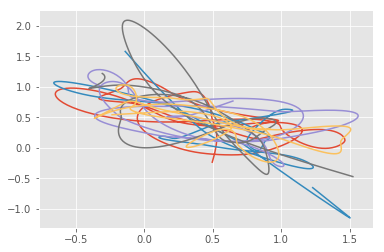

In [4]:
%matplotlib inline
import pylab as pl
pl.style.use("ggplot")

for i in range(N):
    pl.plot(data[:, 0, i], data[:, 1, i])

## 用Bokeh显示动画

In [6]:
from bokeh.io import show
from bokeh.models.callbacks import CustomJS
from bokeh import palettes

下面使用动画显示轨迹数据。质点使用`fig.circle()`绘制，而质点对应轨迹使用`fig.multi_line()`绘制。本例中使用了两个`ColumnDataSource`对象:

* `point_source`: 其中的`x`和`y`为长度为`N`的一维数组，表示质点的坐标。
* `track_source`: 其中的`x`和`y`是形状为`(N, M)`的二维数组，它表示多个质点的运动轨迹，其中`M`为轨迹残留长度。

In [7]:
cx, cy = np.mean(data, axis=(0, 2))
fig = Figure(x_range=(cx-2, cx+2), y_range=(-2, 2), plot_width=500, plot_height=500, id="animation")
colors = palettes.Category20_20[:data.shape[-1]]
point_source = ColumnDataSource(data={"x":data[0][0], "y":data[0][1], "colors":colors})
track_source = ColumnDataSource(data={"x":[[0]] * data.shape[-1], "y":[[0]] * data.shape[-1], "colors":colors})
all_data = ColumnDataSource(data={"data":data})
fig.circle(x="x", y="y", color="colors", source=point_source, size=10)
fig.multi_line(xs="x", ys="y", color="colors", source=track_source)

GlyphRenderer(id='9298f17d-d022-4e12-b7b9-84e880ae8eb9', ...)

浏览器端的程序本应使用Javascript编写，但Bokeh也提供了将Python代码自动转换为Javascript代码的`CustomJS.from_py_func()`函数。
`animate()`对应的Javascript程序运行之后，❶调用`setInterval()`设置每10ms运行一次`callback()`函数。在`callback()`函数中，更新上述两个`ColumnDataSource`对象中的数据，并重绘图表。❷为图表设置点击事件响应函数，但用户同时按住Ctrl和Shift按键，并点击图表时，动画将从头开始播放。这里使用`Bokeh.index["animation"].el`获得与图表对应的HTML文档元素。可是使用JQuery提供的各种功能对其进行处理，这里通过`click()`方法为其添加点击事件响应函数。

❸由于Bokeh没有提供图表初始化之后的Javascript事件，为了让图表显示时就播放动画，需要使用`fig.js_on_change`绑定属性值改变事件。经过一系列的尝试之后，我发现`inner_width`属性在图表显示时会发生改变，因此通过该属性值的改变事件触发动画。

如果希望通过鼠标点击触发动画，可以使用：

    fig.js_on_event("tap", ...)

In [9]:
def animate(point_source=point_source, track_source=track_source, all_data=all_data):
    print("animate")
    data = all_data.get_column("data")
    s0, s1, s2 = all_data._shapes.data
    def val(i, j, k):
        index = s1 * s2 * i + s2 * j + k
        return data[index]
    
    point_data = point_source.data
    track_data = track_source.data
    idx = 0
    track_x = [[] for _ in range(s2)]
    track_y = [[] for _ in range(s2)]
    tid = -1

    def callback():
        nonlocal idx
        for i in range(s2):
            x = val(idx, 0, i)
            y = val(idx, 1, i)
            point_data.x[i] = x
            point_data.y[i] = y
            track_x[i].append(x)
            track_y[i].append(y)
            
            if len(track_x[i]) > 20:
                track_x[i].pop(0)
                track_y[i].pop(0)
        
        track_data.x = track_x
        track_data.y = track_y
        
        point_source.change.emit()
        track_source.change.emit()
        
        idx += 1
        if idx == s0:
            window.clearInterval(tid)
            
    def reset(evt):
        nonlocal idx, tid, track_x, track_y
        if not evt.shiftKey or not evt.ctrlKey:
            return
        window.clearInterval(tid)        
        idx = 0
        track_x = [[] for _ in range(s2)]
        track_y = [[] for _ in range(s2)]
        tid = window.setInterval(callback, 10)
        
    def start():
        nonlocal tid
        tid = window.setInterval(callback, 10)  # ❶
        jQuery(Bokeh.index["animation"].el).click(reset)  # ❷
        
    window.setTimeout(start, 100)
    
fig.js_on_change("inner_width", CustomJS.from_py_func(animate)) # ❸
show(fig)